In [2]:
import math
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def process_raw_df(df):        
    df_data = df.drop(['PassengerId', 'Age', 'Ticket', 'Cabin', 'Name'], axis=1)
    
    df_data['HasCabin'] = df['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
    df_data['Embarked'] = df_data['Embarked'].fillna('S')
    df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())
    
    try:
        se_Y = df_data['Survived']
        df_data = df_data.drop(['Survived'], axis=1)
    except KeyError:
        se_Y = None        
    
    df_data = pd.get_dummies(df_data).drop(['Sex_female', 'Embarked_S'], axis=1)
    return df_data, se_Y

df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

df_Xtrain, se_Ytrain = process_raw_df(df_train)
df_Xtest, _ = process_raw_df(df_test)

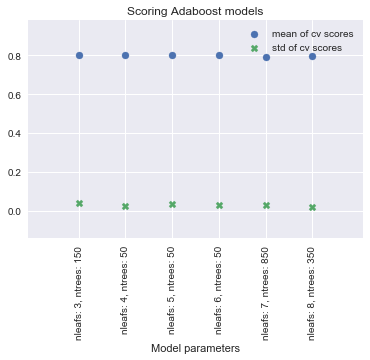

In [3]:
##############################################################################################
# Adaboost
##############################################################################################

n_leafs = list(range(3,9))
n_trees = []
adb_clfs = [] 
for n_leaf in n_leafs:
    # for each n_leaf, find the best number of trees n_tree
    adb = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_leaf_nodes = n_leaf))
    n_tree_grid = {'n_estimators': list(range(50,1050,100))}
    gcv = GridSearchCV(adb, param_grid=n_tree_grid, n_jobs=2, refit=True, cv=5)
    gcv.fit(df_Xtrain, se_Ytrain)
    # best_params_ is a dict like so {'n_estimators': 75} 
    n_trees.append(gcv.best_params_['n_estimators'])
    adb_clfs.append(gcv.best_estimator_)
    
# now score the adb_clfs using Repeated K-Fold
score_means = []
score_stds = []
for n_leaf, n_tree, adb_clf in zip(n_leafs, n_trees, adb_clfs):
    scores = cross_val_score(adb_clf, df_Xtrain, se_Ytrain, cv=5)
    score_means.append(scores.mean())
    score_stds.append(scores.std())

best_adb = adb_clfs[score_means.index(max(score_means))]
    

# plot Adaboost result
plt.figure()
x_tickmarks = ['nleafs: {0}, ntrees: {1}'.format(i, j) for i, j in zip(n_leafs, n_trees)]
plt.scatter(range(len(x_tickmarks)), score_means, marker='o', label='mean of cv scores')
plt.scatter(range(len(x_tickmarks)), score_stds, marker='X', label='std of cv scores')
plt.legend(loc='best')
plt.title('Scoring Adaboost models')
plt.xlabel('Model parameters')
plt.xticks(range(len(x_tickmarks)), x_tickmarks, rotation='vertical')
plt.margins(0.2)
plt.show()

In [4]:
##############################################################################################
# Random Forest
##############################################################################################
rf_param_grid = {'n_estimators': list(range(50,650,100)),
                 'max_features': [0.2, 0.4, 0.6, 0.8],
                 'min_samples_leaf': [1,5,10,20,50]}
gcv = GridSearchCV(RandomForestClassifier(oob_score=True), 
                   param_grid = rf_param_grid, 
                   n_jobs = 2, 
                   refit = True, 
                   cv = 5)
gcv.fit(df_Xtrain, se_Ytrain)
best_rf = gcv.best_estimator_

In [6]:
##############################################################################################
# SVM
##############################################################################################
svm_param_grid = {'kernel': ['rbf', 'sigmoid'],                  
                  'C': np.logspace(-2, 0.5, num=5, base=round(math.exp(1), 4)),
                  'gamma': np.logspace(-4, 4, num=8, base=round(math.exp(1), 4))}
gcv = GridSearchCV(svm.SVC(cache_size=8192), param_grid=svm_param_grid, n_jobs=2, refit=True, cv=5)
gcv.fit(df_Xtrain, se_Ytrain)
best_svm = gcv.best_estimator_

In [8]:
##############################################################################################
# Stacking
##############################################################################################
base_clfs = [best_adb, best_svm, best_rf]
base_model_names = ['Adaboost', 'SVM', 'RF']
base_kfold_predictions = pd.DataFrame({model_name: np.zeros(df_Xtrain.shape[0]) for model_name in base_model_names},
                                       index=df_Xtrain.index) 
base_testset_predictions = pd.DataFrame({model_name: np.zeros(df_Xtest.shape[0]) for model_name in base_model_names},
                                         index=df_Xtest.index)

# with base_clf fully fit on all train data, use each base_clf to predict on test data
for base_clf, model_name in zip(base_clfs, base_model_names):
    base_testset_predictions.loc[:, model_name] = base_clf.predict(df_Xtest)

    # Split the train data to 5 folds. For each fold being the validation_fold:
# Fit the base model to the remaining data and predict on the validation_fold                                      
kf = KFold(n_splits=5, shuffle=True)
for train_indexes, valid_indexes in kf.split(df_Xtrain, se_Ytrain):
    df_kfold_Xtrain, df_kfold_Xvalid = df_Xtrain.loc[train_indexes, :], df_Xtrain.loc[valid_indexes, :]
    se_kfold_Ytrain, se_kfold_Yvalid = se_Ytrain.iloc[train_indexes], se_Ytrain.iloc[valid_indexes]
    
    for base_clf, model_name in zip(base_clfs, base_model_names):
        base_clf.fit(df_kfold_Xtrain, se_kfold_Ytrain)
        base_kfold_predictions.loc[valid_indexes, model_name] = base_clf.predict(df_kfold_Xvalid)

# add base_kfold_predictions as features to df_Xtrain
df_Xtrain = pd.concat([df_Xtrain, base_kfold_predictions], axis=1)
df_Xtest = pd.concat([df_Xtest, base_testset_predictions], axis=1)

stack_clf = GradientBoostingClassifier(n_estimators=250, learning_rate=0.1, max_leaf_nodes=6)
stack_clf.fit(df_Xtrain, se_Ytrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=6,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=250, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [9]:
##############################################################################################
predictions = stack_clf.predict(df_Xtest)
df_submit = pd.DataFrame({'PassengerId': df_test['PassengerId'], 
                          'Survived': predictions})
df_submit.to_csv('submit_stacked.csv', index=False)